Image data (first 5 pixels): [0.21960784 0.29019608 0.20392157 1.         0.21960784]
Generated RGB values (first 5 pixels after scaling and normalizing): [ 0.5718589  0.7329126 -0.3685302  0.5718589  0.7329126]


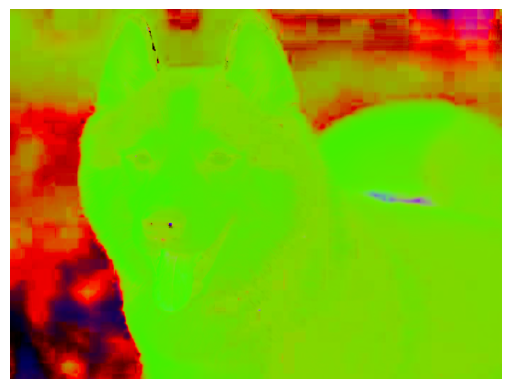

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# Define a simple NeRF model using tanh activation
class NeRF(nn.Module):
    num_layers: int = 8
    hidden_size: int = 256

    @nn.compact
    def __call__(self, x):
        for i in range(self.num_layers):
            x = nn.Dense(self.hidden_size)(x)
            x = nn.tanh(x)  # Use tanh instead of relu or leaky relu
        rgb = nn.Dense(3)(x)  # Output RGB values
        sigma = nn.Dense(1)(x)  # Output density
        return rgb, sigma

# Initialize the NeRF model
def initialize_nerf_model():
    key = jax.random.PRNGKey(0)
    model = NeRF()
    params = model.init(key, jnp.ones((1, 3)))['params']
    return model, params

# Setup optimizer using Optax
def create_optimizer(params):
    tx = optax.adam(learning_rate=1e-3)
    opt_state = tx.init(params)
    return tx, opt_state

# Load custom image and preprocess it
def load_image(image_path):
    image = imageio.imread(image_path)  # Read the image using imageio.v2
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

    # Debug: Print the first 5 pixel values
    print("Image data (first 5 pixels):", image.flatten()[:5])

    if len(image.shape) == 3:  # If it's an RGB image
        image = image[:, :, :3]  # Discard alpha channel if exists
    # Flatten the image to pass as input (Nx3 RGB values)
    image = image.reshape(-1, 3)
    return image

# Render a scene using NeRF (modified to normalize RGB values)
def render_scene_with_image(model, params, image_data):
    rgb, sigma = model.apply({'params': params}, image_data)

    # Scale the RGB values by a factor to enhance output
    rgb = rgb * 10  # Keep the scaling, or adjust it as necessary

    # Normalize the RGB values across the channels
    rgb = rgb / (jnp.linalg.norm(rgb, axis=-1, keepdims=True) +
                 1e-6)  # Normalize across the last axis

    print("Generated RGB values (first 5 pixels after scaling and normalizing):",
          rgb.flatten()[:5])

    rendered_image = jnp.clip(rgb, 0, 1)  # Clip to valid RGB range
    return rendered_image

# Visualize the generated image
def visualize_image(image, img_shape):
    image = image.reshape(img_shape)  # Reshape to original image shape
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Generate a new view using the image
def generate_new_view_with_image(model, params, image_data, img_shape):
    rendered_image = render_scene_with_image(model, params, image_data)
    visualize_image(rendered_image, img_shape)


# Main execution
image_path = 'dog.png'  # Replace with your image path
image_data = load_image(image_path)
img_shape = (imageio.imread(image_path).shape[0], imageio.imread(
    image_path).shape[1], 3)  # Get the original shape

model, params = initialize_nerf_model()
tx, opt_state = create_optimizer(params)

# Generate a new view from the custom image
generate_new_view_with_image(model, params, image_data, img_shape)

In [1]:
from diffusers import StableDiffusionPipeline
import torch
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

# Disable the NSFW filter
def dummy(images, **kwargs):
    return images, [False] * len(images)  # Return a list of booleans, one for each image

# Load the pre-trained model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cpu")

# Disable NSFW filtering by replacing the safety checker with the dummy function
pipe.safety_checker = dummy

# Define a textual prompt
prompt = "A bird standing in a forest"

# Generate an image from the text prompt
image = pipe(prompt).images[0]

# Save or display the generated image
image.save("bird.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
import torch
# This should return True if CUDA is properly configured.
torch.cuda.is_available()

True